In [2]:
# import libraries
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import powerlaw

# Part A: Visualisation

## Exercise 1: Build the right graph for visualization:

## 1. Use NetworkX DiGraph to store the network of characters.    
Remember that characters are linked if they have a corresponding link between their Zelda Wiki contents.

In [3]:
df = pd.read_csv("./ZeldaBotW_nodes_w_attributes_enriched.csv")
df.head()

Name  Role    Race   Gender
0  Baddek  Ally  Hylian     Male
1  Bamboo  Ally   Horse  Unknown
2   Banji  Ally  Hylian   Female
3  Baumar  Ally  Hylian     Male
4   Bayge  Ally   Goron     Male

### Add each character as node&Store their attributes

In [6]:
# count the number of words in each character's page
each_page_length = []
for i in range(0,df.shape[0]):
    node = df.Name.values[i]
    pages_path = "./CharacterDescription/"
    with open(pages_path+node+".txt","r") as f:
        node_description = f.read()
        #  split the sentences into words 
        per_word = node_description.split()
        each_page_length.append(len(per_word))

In [7]:
DiG = nx.DiGraph()

#store 'role','race','gender','content length' as node attributes
for i in range(0,df.shape[0]):
    DiG.add_node(df.Name.values[i],\
                 role= df.Role.values[i],
                 race= df.Race.values[i],
                 gender= df.Gender.values[i],
                 content_length = each_page_length[i])

In [235]:
len(DiG.nodes())

656

### Prepare regx to catch links

In [4]:
# direct links
pattern1 = "\[\[(.*?)(?:\|.*?)?\]\]" 
# links using text & links using plural terms
pattern2 = "\{\{(Term|Plural)\|BotW\|(.*?)\}\}"
# links to pages that have parentheses
pattern3 = "\{\{(Term|Plural)\|Series\|(.*?)\}\}"

In [5]:
# get character name from pattern2,3
def get_name(link):
    lst = []
    for i in link:
        # For structure like this {{Term|Series|Princess Zelda|link|display=Zelda}}
        # it's easy to get the name by split and index the third word
        lst.append(i[1].split('|')[0])
    return lst

### Iterate all nodes to find links in the txt pages we got previously

In [8]:
for node in DiG.nodes():
    pages_path = "./CharacterDescription/"
    # open each character's wiki page
    with open(pages_path+node+".txt","r") as f:
        node_description = f.read()
    # find node's links in their page
    link1 = re.findall(pattern1,node_description)
    link2 = re.findall(pattern2,node_description)
    link2 = get_name(link2)
    link3 = re.findall(pattern3,node_description)
    link3 = get_name(link3)
    links = link1+link2+link3

    for link in links:
        # check if the target is a character
        if link in DiG.nodes():
            DiG.add_edge(node,link)

In [9]:
# num of edges
len(DiG.edges())

1929

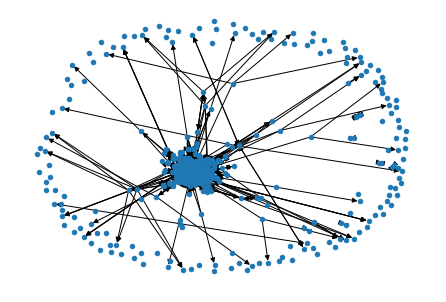

In [401]:
nx.draw(DiG,node_size=20)

**discard isolated nodes**

In [241]:
DiG.remove_nodes_from(list(nx.isolates(DiG)))

In [13]:
print('DiG now has',len(DiG.nodes()),'nodes')

DiG now has 536 nodes


**use weakly connected component to extract the largest component.**

In [242]:
largest = max(nx.weakly_connected_components(DiG),key=len)
dir_larG = DiG.subgraph(largest)
nx.write_gpickle(dir_larG,'./zelda_dirGCC')

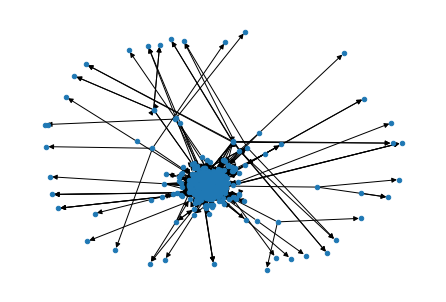

In [404]:
nx.draw(dir_larG,node_size=20)

In [405]:
len(largest)

519

# Exercise 2: build a simple visualization of the network

##  convert our network to undirected graph

In [243]:
larG = dir_larG.to_undirected()

##  draw the resulting undirected network.

### set Node color depending on the role attribute**

**distribute characters to three list based on their role**

In [244]:
# extract nodes with specific setting of the attribute
ally_nodes = [n for (n,rl) in \
    nx.get_node_attributes(larG,'role').items() if rl == 'Ally']
enemy_nodes = [n for (n,rl) in \
    nx.get_node_attributes(larG,'role').items() if rl in ('Enemy','Boss')]
# find all the remaining nodes.
other_nodes = list(set(larG.nodes()) - set(ally_nodes) - set(enemy_nodes))

**set corresponding color list**

In [15]:
nodelst = ally_nodes+enemy_nodes+other_nodes
colors = []
for i in range(len(nodelst)):
    if i < len(ally_nodes):
        colors.append('#41b6e6')
    elif i < len(ally_nodes+enemy_nodes):
        colors.append('#e74c3c')
    else:
        colors.append('#7A57D1')

**get the dictionary of nodes and their degrees**

In [17]:
d = dict(larG.degree)

**set nodes color and size using '\*\*kwargs'**

In [18]:
options_node = {
    'nodelist': nodelst,
    'node_color': colors,
    # set node-size depending on the node degree
    'node_size':[v*10 for v in d.values()],
    'alpha':0.9,
}

**use kamada_kawai_layout to draw the undir network**

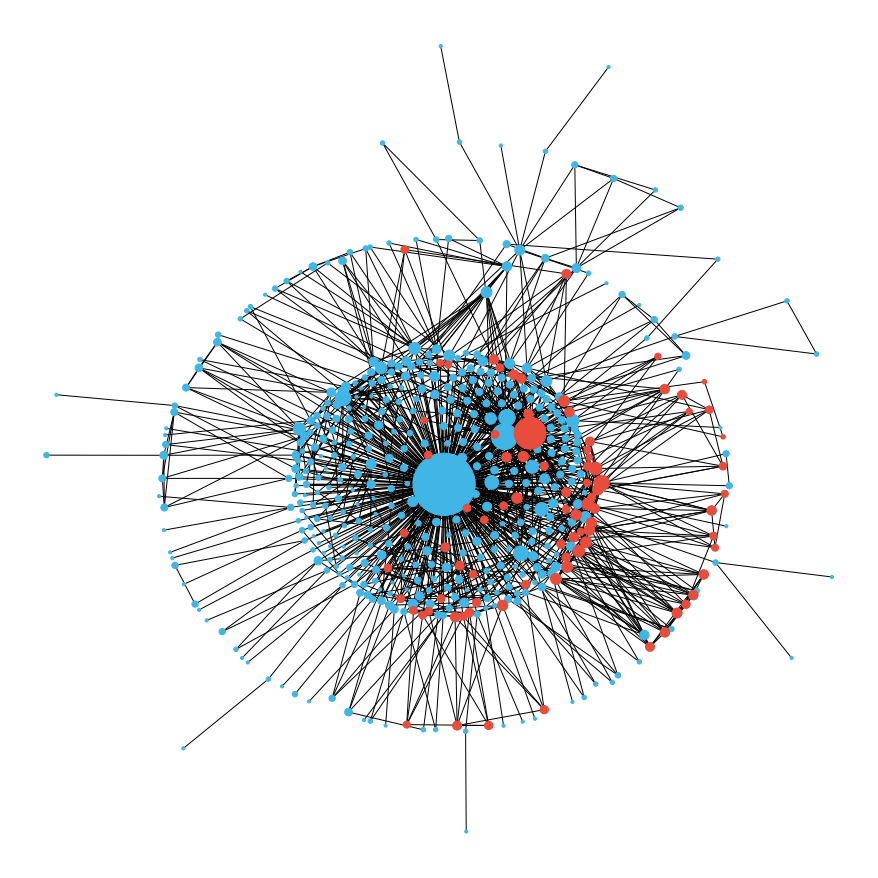

In [310]:
plt.figure(figsize=(12,12))
pos = nx.kamada_kawai_layout(larG)
nx.draw(larG, pos, **options_node)
plt.show()

# Exercise 3: observe structure with ForceAtlas package

## install ForceAtlas2 package
ForceAtlas2 algorithm helps to determine the positions of the nodes<br>
use command <code>pip install fa2</code> to install it

In [284]:
# import fa2
from fa2 import ForceAtlas2

## visualise the network by fa2

In [285]:
# Load the graph edges and compute the node positions using ForceAtlas2
G = larG
forceatlas2 = ForceAtlas2()
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 191.86it/s]

BarnesHut Approximation  took  0.20  seconds
Repulsion forces  took  0.78  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


### Set edge colors
if an edge connects allies assign color_a, if the edge connects enemies/bosses assign color_b, in other cases assign color_c (i.e. when allies connect to either enemies or bosses).

In [47]:
edge_colors = []
for i,j in G.edges():
    if i in ally_nodes and j in ally_nodes:
        edge_colors.append('#41b5e0')
    elif i in enemy_nodes and j in enemy_nodes:
        edge_colors.append('#f06966')
    else:
        edge_colors.append('#42218E')

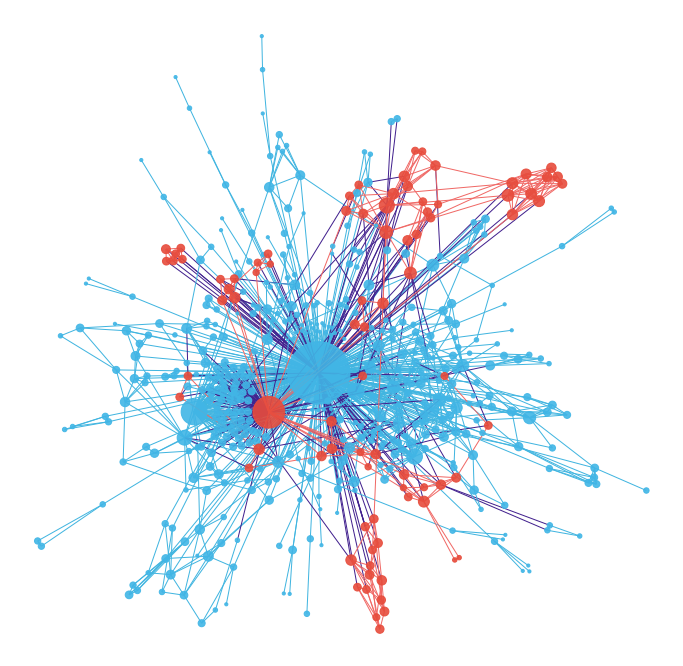

In [48]:
plt.figure(figsize=(12,12))

# draw nodes
nx.draw_networkx_nodes(G,positions, **options_node)

# draw edges
options_edge = {
    'edge_color':edge_colors,
}
nx.draw_networkx_edges(G,positions, **options_edge)

# cancel axis
plt.axis('off')
plt.show()

## Describe the structure you observe.

**Can you identify nodes with a privileged position in the network?**<br>
* Yes, it's very obvious that the more degree a node has, the larger it would be.
* As the network shown, blue represents ally, red represents enemy.<br>
* We can see from the dictionary below that our main character 'Link' has leading amout of degrees than other characters, which indicates that he is the most important character.
* Similarly, the biggst antagonist, 'Calamity Ganon', has second most degree amount, so it's natural to find the second largest node is a red one.

In [103]:
def sort_by_value(d):
    return sorted(d.items(), key=lambda k: k[1],reverse=True)  # k[1] get the dict value

sort_by_value(dict(larG.degree))

[('Link', 389),
 ('Calamity Ganon', 101),
 ('Hylia', 67),
 ('Princess Zelda', 27),
 ('Riju', 24),
 ('Bokoblin', 23),
 ('Purah', 22),
 ('Mipha', 19),
 ('Impa', 18),
 ('Sidon', 17),
 ('Kilton', 16),
 ('Moblin', 16),
 ('Ashai', 15),
 ('Kass', 14),
 ('Traysi', 14),
 ('Lizalfos', 14),
 ('Lynel', 14),
 ('King Rhoam', 13),
 ('King Dorephan', 13),
 ('Daruk', 12),
 ('Revali', 12),
 ('Urbosa', 12),
 ('Robbie', 12),
 ('Electric Lizalfos', 12),
 ('Fire-Breath Lizalfos', 12),
 ('Stalizalfos', 12),
 ('Stone Talus', 12),
 ('Blue Bokoblin', 11),
 ('Fire Wizzrobe', 11),
 ('Guardian Stalker', 11),
 ('Silver Lizalfos', 11),
 ('Stalmoblin', 11),
 ('Yiga Footsoldier', 11),
 ('Hinox', 11),
 ('Hudson', 10),
 ('Old Man', 10),
 ('Bludo', 10),
 ('Vilia', 10),
 ('Teba', 10),
 ('Dorian', 10),
 ('Cursed Lizalfos', 10),
 ('Banji', 9),
 ('Bolson', 9),
 ('Yunobo', 9),
 ('Azu', 9),
 ('Nanna', 9),
 ('Black Bokoblin', 9),
 ('Blue Lizalfos', 9),
 ('Golden Lizalfos', 9),
 ('Golden Lynel', 9),
 ('Guardian Turret', 9),
 ('I

### add labels to the top3 degree nodes

In [93]:
label_dic={node:node for node in G.nodes() if node in ['Link','Calamity Ganon','Hylia']}

options_lab = {
    'labels': label_dic,
    'font_size':10,
    'font_color':'w'
}

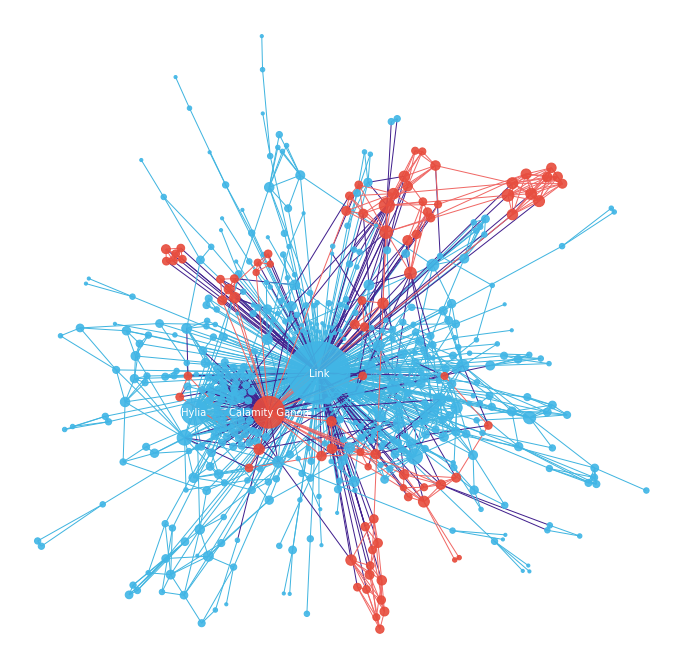

In [94]:
plt.figure(figsize=(12,12))

# draw nodes
nx.draw_networkx_nodes(G,positions, **options_node)
# draw edges
nx.draw_networkx_edges(G,positions, **options_edge)

# draw labels
nx.draw_networkx_labels(G,positions,**options_lab)

# cancel axis
plt.axis('off')
plt.show()

**Do you observe chains of connected nodes?**<br>
Yes, nodes are connected as chains if they have same atrributes. So the red chain is enemy group, the blue chain is ally group.

**Do you see any interesting group of nodes (can you guess who's involved)?<br>**


# Exercise 4: qualitative inspection

##  Top 3 in/out-degree nodes

### Top 3 in-degree nodes

In [412]:
sort_by_value(dict(dir_larG.in_degree())) # sort_by_value is defined on 3.3

[('Link', 386),
 ('Calamity Ganon', 98),
 ('Hylia', 67),
 ('Princess Zelda', 26),
 ('Riju', 23),
 ('Bokoblin', 21),
 ('Purah', 17),
 ('Mipha', 15),
 ('Sidon', 14),
 ('Impa', 14),
 ('Kilton', 13),
 ('Ashai', 13),
 ('Lizalfos', 12),
 ('King Rhoam', 10),
 ('King Dorephan', 10),
 ('Electric Lizalfos', 10),
 ('Fire-Breath Lizalfos', 10),
 ('Moblin', 10),
 ('Bludo', 9),
 ('Golden Lizalfos', 9),
 ('Ice-Breath Lizalfos', 9),
 ('Silver Lizalfos', 9),
 ('Stalizalfos', 9),
 ('Stalkoblin', 9),
 ('Stalmoblin', 9),
 ('Stone Talus', 9),
 ('Hudson', 8),
 ('Kass', 8),
 ('Revali', 8),
 ('Robbie', 8),
 ('Black Lizalfos', 8),
 ('Blue Bokoblin', 8),
 ('Blue Lizalfos', 8),
 ('Lynel', 8),
 ('Bolson', 7),
 ('Daruk', 7),
 ('Urbosa', 7),
 ('Old Man', 7),
 ('Yunobo', 7),
 ('Vilia', 7),
 ('Black Bokoblin', 7),
 ('Cursed Lizalfos', 7),
 ('Guardian Stalker', 7),
 ('Hinox', 7),
 ('Windblight Ganon', 7),
 ('Fireblight Ganon', 7),
 ('Thunderblight Ganon', 7),
 ('Waterblight Ganon', 7),
 ('Dorian', 6),
 ('Electric Kees

The top three in-degree nodes are **'Link','Calamity Ganon' and 'Hylia'**
https://zelda.fandom.com/wiki/Link#Breath_of_the_Wild
https://zelda.fandom.com/wiki/Calamity_Ganon#Breath_of_the_Wild
https://zelda.fandom.com/wiki/Hylia#Breath_of_the_Wild


###  the relation between these 3 characters and his/her network neighbours?

In [176]:
df.query('Name=="Link" | Name=="Calamity Ganon" | Name=="Hylia"')

Name  Role    Race  Gender
26            Hylia  Ally  Hylian  Female
35             Link  Ally  Hylian    Male
654  Calamity Ganon  Boss  Gerudo    Male

In [178]:
HL_neig = [j for j in dir_larG.neighbors('Hylia')]
CG_neig = [j for j in dir_larG.neighbors('Calamity Ganon')]
Link_neig = [j for j in dir_larG.neighbors('Link')]
print('Link\'s neighbors',Link_neig)
print('Calamity Ganon\'s neighbors',CG_neig)
print('Hylia\'s neighbors',HL_neig)

Link's neighbors ['Princess Zelda', 'Epona', 'Impa', 'Hylia', 'Old Man', 'Calamity Ganon', 'King Rhoam', 'Kass', 'Paya', 'Link']
Calamity Ganon's neighbors ['Dark Beast Ganon', 'Fireblight Ganon', 'Thunderblight Ganon', 'Waterblight Ganon', 'Windblight Ganon', 'Calamity Ganon', 'Princess Zelda', 'Link']
Hylia's neighbors ['Princess Zelda', 'Impa']


Link and Hylia are both Hylian and they're allies. All of three connect to Princess Zelda.

### Top 3 out-degree node

In [30]:
sort_by_value(dict(dir_larG.out_degree()))

[('Traysi', 14),
 ('Lizalfos', 13),
 ('Stalizalfos', 12),
 ('Moblin', 11),
 ('Silver Lizalfos', 11),
 ('Stone Talus', 11),
 ('Daruk', 10),
 ('Link', 10),
 ('Impa', 10),
 ('Bokoblin', 10),
 ('Lynel', 10),
 ('Stalmoblin', 10),
 ('Banji', 9),
 ('Kass', 9),
 ('Urbosa', 9),
 ('Purah', 9),
 ('Dorian', 9),
 ('Blue Lizalfos', 9),
 ('Cursed Lizalfos', 9),
 ('Electric Lizalfos', 9),
 ('Fire-Breath Lizalfos', 9),
 ('Fire Wizzrobe', 9),
 ('Ice-Breath Lizalfos', 9),
 ('Yiga Footsoldier', 9),
 ('Chork', 8),
 ('Greyson', 8),
 ('Mipha', 8),
 ('Princess Zelda', 8),
 ('Teba', 8),
 ('Kheel', 8),
 ('Celessa', 8),
 ('Azu', 8),
 ('Nanna', 8),
 ('Black Lizalfos', 8),
 ('Blue Bokoblin', 8),
 ('Golden Lizalfos', 8),
 ('Golden Moblin', 8),
 ('Stalkoblin', 8),
 ('Igneo Talus', 8),
 ('Fireblight Ganon', 8),
 ('Calamity Ganon', 8),
 ('Revali', 7),
 ('Canni', 7),
 ('Pearle', 7),
 ('Canolo', 7),
 ('Harth', 7),
 ('Laruta', 7),
 ('Tumbo', 7),
 ('Nikki', 7),
 ('Paya', 7),
 ('Black Bokoblin', 7),
 ('Golden Lynel', 7),
 

The top three out-degree nodes are **'Traysi','Lizalfos' and 'Stalizalfos'**
https://zelda.fandom.com/wiki/Traysi#Breath_of_the_Wild
https://zelda.fandom.com/wiki/Lizalfos#Breath_of_the_Wild
https://zelda.fandom.com/wiki/Stalizalfos#Breath_of_the_Wild

In [19]:
df.query('Name=="Traysi" | Name=="Lizalfos" | Name=="Stalizalfos"')

Name   Role      Race   Gender
320       Traysi   Ally    Hylian   Female
612     Lizalfos  Enemy  Lizalfos  Unknown
624  Stalizalfos  Enemy  Lizalfos  Unknown

Traysi is one of the most important NPC in BtoW pushing the storyline. Link has a lot of plots with her. That's why she has most in-degrees. And Lizalfos is one of the most important enemies who has many variaties.Stalizalfos is one of them. This is the reason they have second and third most in-degrees.

## Are there any nodes with high out-degree and with few incoming connections? 

We can use $ratio_{in-out}=\frac{in-degree-amount}{out-degree-amount}$ to find nodes with great contrary between in-degree and out-degree. The smaller $ratio_{in-out}$ is, the bigger the contrary, which means high out-degree and few incoming connections.

In [104]:
# save the ratio in a dict
in_out_ratio = {}

# average in_degree and out-degree amount
avg_in_degree = np.mean(list(dict(dir_larG.in_degree).values()))
avg_out_degree = np.mean(list(dict(dir_larG.out_degree).values()))

for i,j in sort_by_value(dict(dir_larG.out_degree())):
    # For high out-degree nodes, I choose those above average out-degree
    if (dir_larG.in_degree[i] != 0) & (j != 0) & (j>avg_out_degree):
        in_out_ratio[i] = dir_larG.in_degree[i]/j
        
# output this dict values from low to high
sorted(in_out_ratio.items(),  key=lambda d: d[1], reverse=False)

[('Banji', 0.1111111111111111),
 ('Chork', 0.125),
 ('Traysi', 0.14285714285714285),
 ('Canni', 0.14285714285714285),
 ('Canolo', 0.14285714285714285),
 ('Laruta', 0.14285714285714285),
 ('Kapson', 0.16666666666666666),
 ('Dai', 0.2),
 ('Babi', 0.2),
 ('Greyson', 0.25),
 ('Kheel', 0.25),
 ('Pikango', 0.25),
 ('Kah Mael', 0.25),
 ("Ke'nai Shakah", 0.25),
 ('Tutsuwa Nima', 0.25),
 ('Ze Kasho', 0.25),
 ('Ritaag Zumo', 0.25),
 ("Tu Ka'loh", 0.25),
 ('Katosa Aug', 0.25),
 ('Zuna Kai', 0.25),
 ('Etsu Korima', 0.25),
 ('Rohta Chigah', 0.25),
 ('Ruvo Korbah', 0.25),
 ('Yowaka Ita', 0.25),
 ('Dah Kaso', 0.25),
 ('Katah Chuki', 0.25),
 ('Namika Ozz', 0.25),
 ('Noya Neha', 0.25),
 ("Saas Ko'sah", 0.25),
 ("Maag No'rah", 0.25),
 ('Mijah Rokee', 0.25),
 ('Shira Gomar', 0.25),
 ('Gorae Torr', 0.25),
 ('Jengo', 0.25),
 ('Daag Chokah', 0.25),
 ('Ketoh Wawai', 0.25),
 ('Kuhn Sidajj', 0.25),
 ('Maag Halan', 0.25),
 ('Pumaag Nitae', 0.25),
 ('Shae Katha', 0.25),
 ('Shoqa Tatone', 0.25),
 ('Dila Maag', 0.

In [78]:
avg_degree_ratio = np.mean(list(in_out_ratio.values()))
print('The average in-degree is:',avg_in_degree)
print('The average degree ratio is:',avg_degree_ratio)

The average in-degree is: 3.678227360308285
The average degree ratio is: 0.8665369751576649


Generally, many nodes have high out-degree with few incoming connections. And they are all basically NPC instead of main characters.

## Are there any nodes with high in-degree and few outcoming connections?

Similarly, we can use $ratio_{out-in}=\frac{out-degree-amount}{in-degree-amount}$ to find nodes with great contrary between in-degree and out-degree. The smaller $ratio_{out-in}$ is, the bigger the contrary, which means high out-degree and few incoming connections.

In [75]:
# save the ratio in a dict
out_in_ratio = {}

for i,j in sort_by_value(dict(dir_larG.in_degree())):
    # For high out-degree nodes, I choose those above average out-degree
    if (dir_larG.out_degree[i] != 0) & (j != 0) & (j>avg_in_degree):
        out_in_ratio[i] = dir_larG.out_degree[i]/j
        
# output this dict values from low to high
sorted(out_in_ratio.items(),  key=lambda d: d[1], reverse=False)

[('Link', 0.025906735751295335),
 ('Hylia', 0.029850746268656716),
 ('Calamity Ganon', 0.08163265306122448),
 ('Sky Octorok', 0.2),
 ('Riju', 0.21739130434782608),
 ('Princess Zelda', 0.3076923076923077),
 ('Kilton', 0.3076923076923077),
 ('Bludo', 0.3333333333333333),
 ('Ashai', 0.38461538461538464),
 ('Olkin', 0.4),
 ('Sidon', 0.42857142857142855),
 ('Bokoblin', 0.47619047619047616),
 ('Hudson', 0.5),
 ('Epona', 0.5),
 ('Rhondson', 0.5),
 ('Kaneli', 0.5),
 ('Karin', 0.5),
 ('Master Kohga', 0.5),
 ('Purah', 0.5294117647058824),
 ('Mipha', 0.5333333333333333),
 ('Old Man', 0.5714285714285714),
 ('Vilia', 0.5714285714285714),
 ('King Rhoam', 0.6),
 ('King Dorephan', 0.6),
 ('Sayge', 0.6),
 ('Electric Chuchu', 0.6),
 ('Sentry', 0.6),
 ('White-Maned Lynel', 0.6),
 ('Fire Keese', 0.6666666666666666),
 ('Ice Chuchu', 0.6666666666666666),
 ('Impa', 0.7142857142857143),
 ('Bolson', 0.7142857142857143),
 ('Robbie', 0.75),
 ('Gleema', 0.75),
 ('Kaifa', 0.75),
 ('Teake', 0.75),
 ('Dento', 0.75),

In [79]:
avg_degree_ratio = np.mean(list(out_in_ratio.values()))
print('The average out-degree is:',avg_out_degree)
print('The average degree ratio is:',avg_degree_ratio)

The average out-degree is: 3.678227360308285
The average degree ratio is: 1.0200680978084065


Link, Hylia, Calamity Ganon have overwhelming in-degree compared with outcoming connections.Amazingly, average in-degree and average out-degree is of same number.

## From the plot of the network (in Exercise 3), we can see that 2 nodes with highest degrees (other than Link) have many common neighbors.

### Can you identify who these characters are? Are they opponents? How many common neighbors do they have?

In [191]:
from collections import Counter
neig = dict(Counter(Link_neig+HL_neig+CG_neig))
print ({key:value for key,value in neig.items()if value > 1})

{'Princess Zelda': 3, 'Impa': 2, 'Calamity Ganon': 2, 'Link': 2}


In [192]:
# common neighbors
def find_common_neighbors(a,b):
    common_neighbor_lst = []
    for i in a:
        for j in b:
            if i == j:
                common_neighbor_lst.append(a)
    return len(common_neighbor_lst)

In [193]:
print('Link and Hylia:',find_common_neighbors(Link_neig,HL_neig))
print('Link and Calamity Ganon:',find_common_neighbors(Link_neig,CG_neig))
print('Calamity Ganon and Hylia:',find_common_neighbors(HL_neig,CG_neig))

Link and Hylia: 2
Link and Calamity Ganon: 3
Calamity Ganon and Hylia: 1


### Can you characterize the common neighbors in terms of their Gender and Race? What about their Zelda Wiki pages (do they have a specific role in the BotW story)?
 

**characterize the common neighbors in terms of their Gender**

In [187]:
# extract nodes according to Gender
male_nodes = [n for (n,rl) in \
    nx.get_node_attributes(larG,'gender').items() if rl == 'male']
female_nodes = [n for (n,rl) in \
    nx.get_node_attributes(larG,'gender').items() if rl in ('female')]
# find all the remaining nodes.
unknown_nodes = list(set(larG.nodes()) - set(ally_nodes) - set(enemy_nodes))
gender_nodes = unknown_nodes+male_nodes+female_nodes

**characterize the common neighbors in terms of their Gender**

In [ ]:
# extract nodes according to Race


In [ ]:
# Set color according to Gender/Race


# Part B: Advanced tools

## Exercise 1

### the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree?

In [108]:
# The value of average in-degree has been calculated in 4.2
median_in_degree = np.median(list(dict(dir_larG.in_degree).values()))
mode_in_degree =  stats.mode(list(dict(dir_larG.in_degree).values()))
min_in_degree = np.min(list(dict(dir_larG.in_degree).values()))
max_in_degree = np.max(list(dict(dir_larG.in_degree).values()))
print('The avg_in_degree is:',avg_in_degree)
print('The median_in_degree is:',median_in_degree)
print('The mode_in_degree is:',mode_in_degree)
print('The min_in_degree is:',min_in_degree)
print('The max_in_degree is:',max_in_degree)

The avg_in_degree is: 3.678227360308285
The median_in_degree is: 2.0
The mode_in_degree is: ModeResult(mode=array([1]), count=array([158]))
The min_in_degree is: 0
The max_in_degree is: 386


The mode of in-degree is larger than the median, which indicates the in-degree had has an unbalanced distribution. This is because the in-degree extreme value is distinctively larger than the average value. 

In [194]:
# The value of average out-degree has been calculated in 4.2
median_out_degree = np.median(list(dict(dir_larG.out_degree).values()))
mode_out_degree =  stats.mode(list(dict(dir_larG.out_degree).values()))
min_out_degree = np.min(list(dict(dir_larG.out_degree).values()))
max_out_degree = np.max(list(dict(dir_larG.out_degree).values()))
print('The avg_out_degree is:',avg_out_degree)
print('The median_out_degree is:',median_out_degree)
print('The mode_out_degree is:',mode_out_degree)
print('The min_out_degree is:',min_out_degree)
print('The max_out_degree is:',max_out_degree)

The avg_out_degree is: 3.678227360308285
The median_out_degree is: 4.0
The mode_out_degree is: ModeResult(mode=array([4]), count=array([122]))
The min_out_degree is: 0
The max_out_degree is: 14


The mode value of the out-degree is as same as the median value of the out-degree and close to its average value. So out-degree distribution is more flat than that of in-degree.

**On top of that, calculate same statistics separately for the network that is spanned only by allies and only by opponents (i.e. enemies and bosses together). How do you interpret the results?**

**Repeat the last step, but for the network that is spanned only by females and only by males. How do you interpret the results?**

### look at the exponent of the degree distribution

In [164]:
data = list(dict(dir_larG.in_degree).values())
fit1 = powerlaw.Fit(data)
print('The exponent of the in-degree distribution is:',fit1.alpha)
data = list(dict(dir_larG.out_degree).values())
fit2 = powerlaw.Fit(data)
print('The exponent of the out-degree distribution is:',fit2.alpha)

Calculating best minimal value for power law fit
The exponent of the in-degree distribution is: 3.344225052789243
Calculating best minimal value for power law fit
The exponent of the out-degree distribution is: 4.800118075013094


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


The exponent of the in-degree distribution is smaller than that of out-degree, which implies that ...

### Plot a scatter plot of the the in- versus out- degree for all characters.

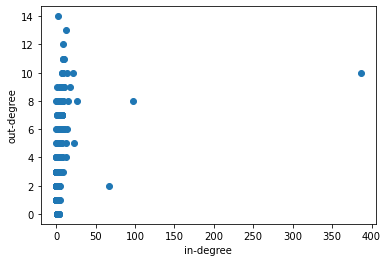

In [203]:
in_x = list(dict(dir_larG.in_degree).values())
out_y = list(dict(dir_larG.out_degree).values())
    
ax = plt.scatter(in_x,out_y)
plt.xlabel('in-degree')
plt.ylabel('out-degree')
plt.show()

### Plot a heatmap (Hint here) of the the in- versus out- degree for all characters. 

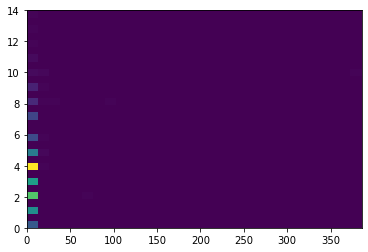

In [228]:
plt.hist2d(in_x,out_y,bins=30)
plt.show()

### Why do you think I want you guys to use a directed graph? Could have we used an undirected graph instead?

By using a directed graph, we can analyse the links between nodes from two perspective,namely in and out. If we use undirected graph, then the links between nodes will have no direction, which means we can't tell the difference between in and out of degrees.The in- and out- degrees will be calculated as a whole for every node they connect.

### We have one more metric that we did not use. The node-attribute content lenght. There are two things we can investigate here.
**Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree.**

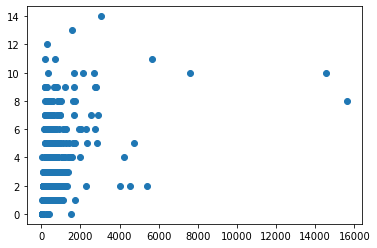

In [260]:
each_length = nx.get_node_attributes(larG,'content_length').values()
plt.scatter(each_length,out_y)

It's not true. The graph shows the length and out-degree has no correlation.

**Secondly, and more interestingly, it could be that longer texts means more famous characters. And that means more in-links.**

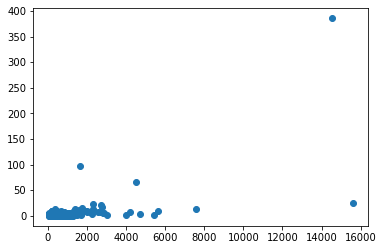

In [261]:
plt.scatter(each_length,in_x)

Generally, the node with larger content length doesn't really mean this character is famous. However, there are outliers fitting our assumption. The node wiki with about 15000 words has the highest in-degree(400).

## Exercise 2: Centralities, assortativity and more

### Find the 5 most central characters according to degree centrality.

In [274]:
DC = sort_by_value(nx.degree_centrality(larG))
DC[0:5]

[('Link', 0.750965250965251),
 ('Calamity Ganon', 0.19498069498069498),
 ('Hylia', 0.12934362934362933),
 ('Princess Zelda', 0.052123552123552123),
 ('Riju', 0.04633204633204634)]

### Find the 5 most central characters according to betweenness centrality.

In [275]:
BC = sort_by_value(nx.betweenness_centrality(larG))
BC[0:5]

[('Link', 0.9316389590711456),
 ('Calamity Ganon', 0.03435337267839812),
 ('Bludo', 0.024486824852638235),
 ('Daruk', 0.021246942249524364),
 ('Kass', 0.017268940975680477)]

### Find the 5 most central characters according to eigenvector centrality. 

In [276]:
EC = sort_by_value(nx.eigenvector_centrality(larG))
EC[0:5]

[('Link', 0.632328831270225),
 ('Calamity Ganon', 0.22902611665058334),
 ('Hylia', 0.15726516739574956),
 ('Princess Zelda', 0.09149864613645398),
 ('Impa', 0.07318001746608704)]

**Repeat Exercise A2 or A3 use eigenvector centrality to define the size of the node.**

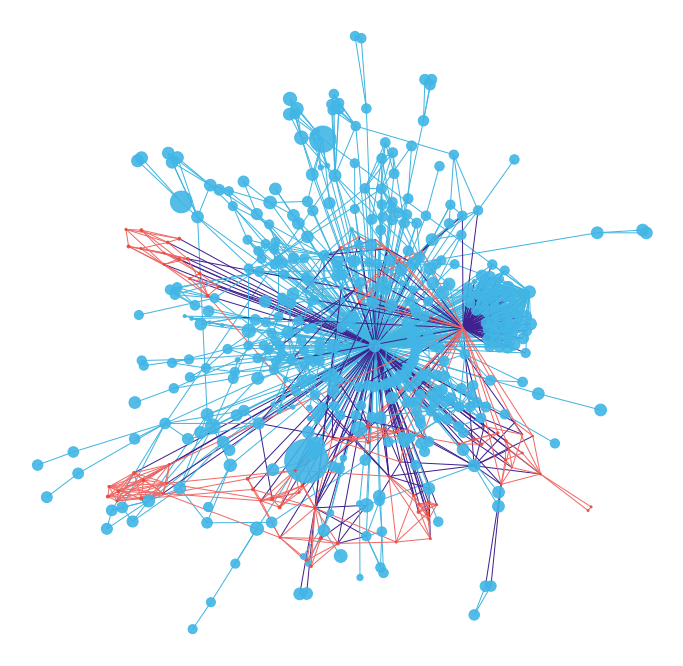

In [305]:
options_node2 = {
    'nodelist': nodelst,
    'node_color': colors,
    # set node-size depending on options_node_eigenvector
    'node_size':[v[1]*3000 for v in EC],
    'alpha':0.9,
}

plt.figure(figsize=(12,12))

# draw nodes
nx.draw_networkx_nodes(larG,positions, **options_node2)

# draw edges
options_edge = {
    'edge_color':edge_colors,
}
nx.draw_networkx_edges(larG,positions, **options_edge)

# cancel axis
plt.axis('off')
plt.show()

**What role do you imagine characters with high wikipedia graph eigenvector centrality play?**

 ### Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.

### Is the undirected version of the graph assortative with respect do the content length nodal properties? (e.g. do characters with long Zelda Wiki pages tend to link to other characters with long Wiki pages, and vice versa?. Hint: Use this function. Provide an interpretation of your answer.

### Is the undirected version of the graph assortative with respect to Role, Race, and Gender? (e.g. allies tend to link to allies, bosses to bosses, and enemies to enemies). Provide an interpretation of your answer.

### What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes N and probablity of connection p?

## Exercise 3: Is the role of a character important for the network structure?

In [ ]:
# Part B: Advanced tools

## Exercise 1

### the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree?



### look at the exponent of the degree distribution



### Plot a scatter plot of the the in- versus out- degree for all characters.



### Plot a heatmap (Hint here) of the the in- versus out- degree for all characters. 





## Exercise 2: Centralities, assortativity and more



## Exercise 3: Is the role of a character important for the network structure?

colors = []
for i in range(len(gender_nodes)):
    if i < len(male_nodes):
        colors.append('#41b6e6')
    elif i < len(male_nodes+female_nodes):
        colors.append('#e74c3c')
    else:
        colors.append('#7A57D1')

## Exercise 3: Is the role of a character important for the network structure? Let us explore if and how it shapes the network (use the undirected network).